$$TASK-2 $$ 
To familiarize yourself with the basic workflow in Quantum Machine Learning, work through the tutorial on Variational Classifier. Implement and present the usual steps in this workflow and explain in your own words the purpose of each step.

Here we installed pennylane on our local IDE(VsCode) for better understanding of Variational Classifier.

In [ ]:
pip install pennylane --upgrade

In this program, we saw how to use PennyLane to implement variational quantum classifiers - quantum circuits that can be trained from labelled data to classify new data samples. We used two examples for this which are inspired by two of the first papers that proposed variational circuits as supervised machine learning models: Farhi and Neven (2018) as well as Schuld et al. (2018).

### EXAMPLE 1: Fitting the parity function 

It shows that a variational circuit can be optimized to emulate the parity function   
                    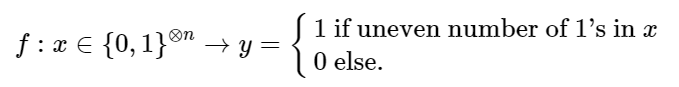
                    
It demonstrates how to encode binary inputs into the initial state of the variational circuit, which is simply a computational basis state (basis encoding).

**1. Imports**

First, we need to import the necessary libraries. We'll use PennyLane for quantum operations, PennyLane's version of NumPy for numerical operations, and an optimizer for training the quantum circuit.


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer                                                                                                        

**2. Quantum Device Initialization**

We define the quantum device that will be used to simulate our quantum circuit. Here, we use the default.qubit device provided by PennyLane, which is a classical simulator of a quantum computer.

**•	default.qubit :** This is a statevector simulator that simulates the behavior of a quantum computer.

**•	wires=4 :** We specify that our quantum circuit will use 4 qubits (wires).


In [ ]:
dev = qml.device("default.qubit")

**3. Circuit Layer Definition**

Next, we define a function to create a single layer of our quantum circuit. A layer consists of arbitrary rotations on each qubit followed by a series of CNOT gates that entangle neighboring qubits.

**• qml.Rot :** This gate applies an arbitrary rotation on a qubit, parameterized by three angles.

**• CNOT gates :** These gates are used to entangle qubits. Entanglement is essential for creating quantum correlations between qubits.


In [ ]:
def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

**4. State Preparation**

The input data (bitstrings) needs to be encoded into the quantum circuit. The state preparation function does this by setting the quantum state to correspond to the bitstring.

**•	qml.BasisState :** This function prepares the qubits in a specific computational basis state based on the input bitstring x.

In [ ]:
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

**5. Variational Quantum Circuit**

We define the full variational quantum circuit by combining the state preparation and the repeated layers of rotations and CNOT gates.

**•	@qml.qnode(dev) :** This decorator converts the circuit function into a quantum node (QNode) that can be executed on the quantum device dev.

**•	qml.expval(qml.PauliZ(0)) :** This measures the expectation value of the Pauli-Z operator on the first qubit, which serves as the output of the quantum circuit.


In [ ]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

**6. Variational Classifier**

We then define the full variational classifier model, which includes the quantum circuit and a classical bias term.

**•	Bias :** The bias term is added to the output of the quantum circuit to form the final prediction.

In [ ]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

**7. Cost Function**

A)  The cost function is a crucial part of training machine learning models. Here, we use the square loss function, which         measures the difference between the predicted and true labels.

**•	np.mean :** Calculates the mean of the squared differences between the predicted and true labels.

In [ ]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

B)  Additionally, we define the accuracy metric to evaluate how well the classifier is performing.

**•	Accuracy :** This function calculates the proportion of predictions that match the true labels.

In [ ]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

C)  Finally, we define the cost function that will be minimized during training.

**•	X and Y :** These represent the input data and corresponding labels, respectively.

In [ ]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

**8. Optimization**

Now, let's load and preprocess the data, initialize the model parameters, and train the model.


In [ ]:
data = np.loadtxt("ENTER TASK_2_Example1_TRAIN dataset HERE", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

We initialize the variables randomly (but fix a seed for reproducibility). Remember that one of the variables is used as a bias, while the rest is fed into the gates of the variational circuit.

**•	num_layers = 2 :** The number of layers in the quantum circuit.

**•	weights_init :** Randomly initialized weights for the circuit.


In [ ]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Next we create an optimizer instance and choose a batch size…

In [ ]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

**9. Results**

We run the optimizer to train our model. We track the accuracy - the share of correctly classified data samples. For this we compute the outputs of the variational classifier and turn them into predictions in  {
−
1
,
1
}
  by taking the sign of the output.



In [ ]:
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

**10. Testing on Unseen Data**

To evaluate the generalization of the model, we test it on unseen data.


In [ ]:
data = np.loadtxt("ENTER TASK_2_Example1_TEST dataset HERE", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

**Conclusion**

The variational quantum classifier was successfully implemented and trained to recognize the parity function using a small synthetic dataset. This example demonstrates the core steps in building and training a quantum machine learning model using PennyLane.


..

### EXAMPLE 2 : IRIS CLASSIFICATION

**Problem Overview**

We want to classify data points from the Iris dataset using a quantum variational classifier. The data points are represented as real-valued vectors, which will be encoded into quantum states. Specifically, we will use a quantum circuit with 2 qubits to represent 2-dimensional input vectors (with some additional latent dimensions).


**1. Quantum State Preparation**

First, we need to prepare the quantum states based on the input vectors. The state preparation routine takes a vector x and converts it into a set of rotation angles that can be used to prepare the quantum state.

•	The **get_angles** function converts the input vector x into a set of angles.

•	These angles are computed based on the magnitude of the elements of the vector.


In [ ]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


**State Preparation Circuit :**

•	The **state_preparation** function prepares the quantum state using the angles a computed from the input vector x.

•	It uses a series of rotations (qml.RY) and controlled NOT gates (qml.CNOT) to prepare the desired quantum state.


In [ ]:
def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

**Testing the State Preparation :**

•	We test the state preparation by feeding it a sample input vector x.

•	The output shows that the quantum state has been prepared correctly based on the input vector.

•   The method computed the correct angles to prepare the desired state!


In [ ]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

Since we are working with only 2 qubits now, we need to update the layer function. In addition, we redefine the cost function to pass the full batch of data to the state preparation of the circuit simultaneously, a technique similar to NumPy broadcasting.

In [ ]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])


def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

**2. Data Preprocessing**

The Iris dataset is loaded, and the input vectors are padded and normalized. This preprocessing is crucial for ensuring that the data can be encoded into quantum states.

•	The data points are padded to size 4 to match the size of the state vector in the quantum device.

•	The padded data points are then normalized.

•	Finally, the get_angles function is used to convert the normalized data into rotation angles.

In [ ]:
data = np.loadtxt("Enter your TEST_2_Example2_IRIS DATASET HERE")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]

**Visualizing Preprocessing :**

•	The original, normalized, and feature-transformed data are visualized to see how the preprocessing affects the data distribution.

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

**3. Model Training**

We split the data into training and validation sets and initialize the quantum variational classifier.

•	The dataset is split into training and validation sets to monitor generalization performance.

In [ ]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

**Optimization :**


In [ ]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

•	The weights and biases of the variational classifier are updated in each iteration using the **NesterovMomentumOptimizer**.

•	The training and validation accuracy are computed and printed every few iterations.


In [ ]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

**4. Results Visualization**

Finally, we visualize the decision boundary learned by the variational classifier.

•	The decision boundary is visualized, showing how well the classifier can separate the two classes.

In [ ]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()

**Summary**

This step-by-step approach allows us to understand how quantum variational classifiers work and how to implement them using PennyLane.